In [2]:
import numpy as np
import pandas as pd
import os
import grelu.data.preprocess
import grelu.data.dataset
import grelu.lightning
import grelu.visualize
import pickle
import pyBigWig

/Users/sach/Desktop/Markdown_Book/notebook_tutorials/venv/lib/python3.11/site-packages/enformer_pytorch/modeling_enformer.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [3]:
# Model constants
INPUT_WINDOW = 2048
OUTPUT_WINDOW = 512
PRED_RES = 512
buffer_bp = (INPUT_WINDOW-OUTPUT_WINDOW)//2
val_chroms = "chr3"
test_chroms = "chr2"
genome = "hg38"
bw_file =  'ENCFF601VTB.bigWig' #p-value #'ENCFF359FNY.bigWig' #fold change


# Model will predict on chromsomes 1
CHROMOSOMES =np.array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5'])


# hg38 chrom lengths
# Human Genome Assembly GRCh38.p14
CHROM_LEN =np.array([248_956_422, 242_193_529, 198_295_559, 190_214_555, 181_538_259, 170_805_979, 
                     159_345_973, 145_138_636, 138_394_717, 133_797_422, 135_086_622, 133_275_309,
                     114_364_328, 107_043_718, 101_991_189, 90_338_345, 83_257_441, 80_373_285,
                     58_617_616, 64_444_167, 46_709_983, 50_818_468])


# URLs of the BigWig files
urls = [
    'ENCFF601VTB.bigWig' # p-values
    #'ENCFF359FNY.bigWig' # Fold change
]

In [ ]:
def load_y(data: dict,#pybigwig object
           labels: list,
           selected_chromosome: chr,
           window_start: int,
           window_size: int,
           target_bp:int,
           pred_res: int):
    
    """Function to load target y values from bigwigs"""
    #get buffer amount between input and output - centre output
    buffer_bp = (window_size-target_bp)//2
    target_length = target_bp//pred_res    
    # Output labels only for selected cells
    all_y = np.zeros(shape=(target_length, len(labels)))
    for i, label in enumerate(labels):
        #data at pred_res bp lvl already but loaded in at 1bp lvl
        #need to avg back up!
        # Data is arcsinh transformed to deal help with different seq depths
        all_y[:, i] = np.arcsinh(np.mean( 
            np.nan_to_num(
                data[label].values(
                    selected_chromosome,
                    window_start+buffer_bp,
                    window_start+buffer_bp+target_bp,
                    numpy=True
                )
            ).reshape(-1, pred_res),#averaging at desired pred_res  
            axis=1))
    return all_y

In [ ]:
# Main 1

# Create a dict of all bigwigs
bw_dat = {}
for url in urls:
    bw = pyBigWig.open(url)
    if bw is not None:
        bw_dat[url] = bw



# Setting up the dna bins and dataframe
for ind,chrom_i in enumerate(CHROMOSOMES):
    bins = np.arange(buffer_bp,CHROM_LEN[ind]-buffer_bp,INPUT_WINDOW)
    #store in pd df
    if(ind==0):
        dna_bins = pd.DataFrame({
            'chrom': chrom_i,
            'pred_strt': bins,
            'pred_end': bins+OUTPUT_WINDOW,
            'start': bins-buffer_bp,
            'end': bins+OUTPUT_WINDOW+buffer_bp
        })
    else:
        tmp = pd.DataFrame({
            'chrom': chrom_i,
            'pred_strt': bins,
            'pred_end': bins+OUTPUT_WINDOW,
            'start': bins-buffer_bp,
            'end': bins+OUTPUT_WINDOW+buffer_bp
        })
        dna_bins = pd.concat([dna_bins, tmp])
dna_bins = dna_bins.reset_index()
print(dna_bins)

In [ ]:
# Main 2 - Attaching coverage values to dataframe and saving as a csv.gz file


# For each bin, load the data and find the max coverage
cov = []
for index, row in dna_bins.iterrows():
    if(index%20_000==0):
        print(row['chrom'] +": "+str(row['pred_strt']))  
    dna_strt = row['start'] 
    the_chr = row['chrom']
    all_y = load_y(data=bw_dat,
                    labels=urls,
                    selected_chromosome=the_chr,
                    window_start=dna_strt,
                    window_size = INPUT_WINDOW,
                    target_bp = OUTPUT_WINDOW,
                    pred_res = PRED_RES)
    #save max coverage
    cov.append(np.max(all_y))

#add cov to data
dna_bins['cov'] = cov



# Save the data as a compressed csv file

dna_bins.to_csv('data/512bpResolution_p_values.csv.gz',
                index=False,compression='gzip')


print(dna_bins)

In [43]:
# Load our DNA bins filled with our target values
dna_bins = pd.read_csv('data/512bpResolution_p_values.csv.gz')

# Set a threshold to filter our data
threshold = 2
threshold = np.arcsinh(threshold) # The threshold has to undergo an arcsinh transformation as well


# balanced data sets (add negative regions later)

filt_dna_bins = dna_bins.loc[dna_bins['cov']>threshold].reset_index(drop=True) # Apply the threshold to all chromosomes
print(f"{filt_dna_bins.shape[0]} training/validation/test positions.")



# real distribution test set
'''
# Separate data for chromosome 2 from all other chromosomes
chrom2_data = dna_bins[dna_bins['chrom'] == 'chr2'] 
other_chromosomes_data = dna_bins[(dna_bins['chrom'] != 'chr2')]

# Apply the threshold to the other chromosomes
filtered_other_chromosomes_data = other_chromosomes_data[other_chromosomes_data['cov'] > threshold]

# Combine the filtered data with the chromosome 2 data (no threshold applied)
filt_dna_bins = pd.concat([filtered_other_chromosomes_data, chrom2_data])

# Reset index and print the number of positions
filt_dna_bins = filt_dna_bins.reset_index(drop=True)
print(f"{filt_dna_bins.shape[0]} training/validation/test positions.")
'''



# real distribution validation and test set
'''
chrom2_data = dna_bins[dna_bins['chrom'] == 'chr2'] 
chrom3_data = dna_bins[dna_bins['chrom'] == 'chr3']
other_chromosomes_data = dna_bins[(dna_bins['chrom'] != 'chr2') & (dna_bins['chrom'] != 'chr3')]

# Apply the threshold to the other chromosomes
filtered_other_chromosomes_data = other_chromosomes_data[other_chromosomes_data['cov'] > threshold]

# Combine the filtered data with the chromosome 2 data (no threshold applied)
filt_dna_bins = pd.concat([filtered_other_chromosomes_data, chrom2_data, chrom3_data])

# Reset index and print the number of positions
filt_dna_bins = filt_dna_bins.reset_index(drop=True)
print(f"{filt_dna_bins.shape[0]} training/validation/test positions.")
'''

137474 training/validation/test positions.


'\nchrom2_data = dna_bins[dna_bins[\'chrom\'] == \'chr2\'] \nchrom3_data = dna_bins[dna_bins[\'chrom\'] == \'chr3\']\nother_chromosomes_data = dna_bins[(dna_bins[\'chrom\'] != \'chr2\') & (dna_bins[\'chrom\'] != \'chr3\')]\n\n# Apply the threshold to the other chromosomes\nfiltered_other_chromosomes_data = other_chromosomes_data[other_chromosomes_data[\'cov\'] > threshold]\n\n# Combine the filtered data with the chromosome 2 data (no threshold applied)\nfilt_dna_bins = pd.concat([filtered_other_chromosomes_data, chrom2_data, chrom3_data])\n\n# Reset index and print the number of positions\nfilt_dna_bins = filt_dna_bins.reset_index(drop=True)\nprint(f"{filt_dna_bins.shape[0]} training/validation/test positions.")\n'

In [44]:
# Keep only the 'chrom', 'start', and 'end' columns
peaks = filt_dna_bins[['chrom', 'start', 'end']]
print(peaks)

       chrom      start        end
0       chr1     833536     835584
1       chr1     841728     843776
2       chr1     847872     849920
3       chr1     854016     856064
4       chr1     905216     907264
...      ...        ...        ...
137469  chr2  242182144  242184192
137470  chr2  242184192  242186240
137471  chr2  242186240  242188288
137472  chr2  242188288  242190336
137473  chr2  242190336  242192384

[137474 rows x 3 columns]


In [6]:
peaks = grelu.data.preprocess.filter_blacklist(
        peaks,
        genome=genome,
        window=50 # Remove peaks if they are within 50 bp of a blacklist region
    )

Keeping 25088 intervals


In [7]:
negatives = grelu.data.preprocess.get_gc_matched_intervals(
    peaks,
    binwidth=0.02, # resolution of measuring GC content
    genome=genome,
    chroms=['chr1', 'chr2', 'chr3', 'chr4', 'chr5'], # balanced train/val/test
    #chroms=['chr1', 'chr3', 'chr4', 'chr5'], # real distribution test set
    #chroms=['chr1', 'chr4', 'chr5'], # real distribution validation and test set
    blacklist=genome, # negative regions overlapping the blacklist will be dropped
    seed=0,
    )
negatives.head(3)

Calculating GC content genomewide and saving to gc_hg38_2048.bw


Writing: 100%|████████████████████████████████████| 5/5 [02:13<00:00, 26.64s/it]


Extracting matching intervals


100%|██████████████████████████████████| 25088/25088 [00:01<00:00, 14479.53it/s]

GC paired t-test: 0.00546, 0.846
Filtering blacklist
Keeping 24414 intervals


,chrom,start,end
0,chr1,203672420,203674468
1,chr1,37605617,37607665
2,chr1,67218724,67220772


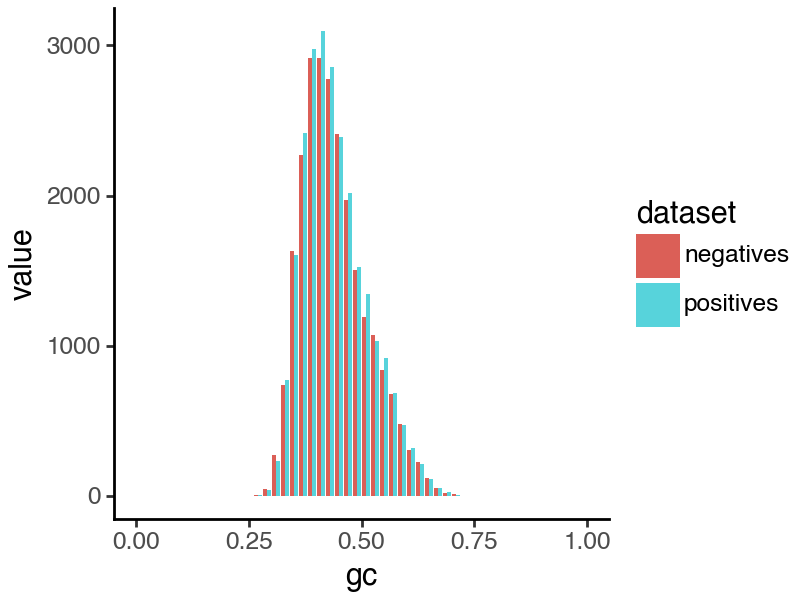

In [8]:
import grelu.visualize
grelu.visualize.plot_gc_match(
        positives=peaks, negatives=negatives, binwidth=0.02, genome="hg38", figsize=(4, 3)
    )

In [9]:
regions = pd.concat([peaks, negatives])
len(regions)

49502

In [10]:
print(regions)

      chrom      start        end
0      chr1     833536     835584
1      chr1     841728     843776
2      chr1     847872     849920
3      chr1     854016     856064
4      chr1     905216     907264
...     ...        ...        ...
25083  chr3   61829290   61831338
25084  chr1  196762810  196764858
25085  chr2   26666219   26668267
25086  chr4   13360703   13362751
25087  chr1   38080150   38082198

[49502 rows x 3 columns]


In [34]:
from sklearn.utils import resample

train_size = 12000
valid_size = 1500
test_size = 1500

# 1. Filter the data by chromosome
chr2_data = regions[regions['chrom'] == test_chroms]
chr3_data = regions[regions['chrom'] == val_chroms]
train_data = regions[~regions['chrom'].isin([test_chroms, val_chroms])]

# 2. Downsample chr2 and chr3 data if necessary
if len(chr2_data) > test_size:
    chr2_data = resample(chr2_data, n_samples=test_size, random_state=1)

if len(chr3_data) > valid_size:
    chr3_data = resample(chr3_data, n_samples=valid_size, random_state=1)

# 3. Downsample the training data to 12,000 if necessary
if len(train_data) > train_size:
    train_data = resample(train_data, n_samples=train_size, random_state=1)

# 4. Combine the final training, validation, and test sets
train = train_data
val = chr3_data
test = chr2_data

# 5. Print the sizes of each split to verify
print("Training set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

Training set size: 12000
Validation set size: 1500
Test set size: 1500


In [ ]:
# Not Splitting Sets By Chromosome

'''
from sklearn.utils import shuffle

# Shuffle the entire dataset
regions = shuffle(regions, random_state=1)

# Randomly select 12,000 samples for the training set
train = regions.sample(n=12000, random_state=1)
remainder = regions.drop(train.index)

# Randomly select 1,500 samples for the validation set from the remainder
val = remainder.sample(n=1500, random_state=1)

# The remaining 1,500 samples in the remainder will be the test set
test = remainder.drop(val.index).sample(n=1500, random_state=1)

# Print the sizes of each split to verify
print("Training set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))
'''

In [35]:
import grelu.data.dataset
    
train_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = train,
    bw_files=[bw_file],
    label_len=PRED_RES,
    label_aggfunc="sum",
    #rc=True, # reverse complement
    #max_seq_shift=2, # Shift the sequence
    #augment_mode="random",
    seed=0,
    genome=genome,
    label_transform_func=np.arcsinh
)

In [36]:
val_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = val,
    bw_files=[bw_file],
    label_len=PRED_RES,
    label_aggfunc="sum", 
    genome=genome,
    label_transform_func=np.arcsinh
)

test_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = test,
    bw_files=[bw_file],
    label_len=PRED_RES,
    label_aggfunc="sum",
    genome=genome,
    label_transform_func=arcsinh_transform
)

len(train_ds), len(val_ds), len(test_ds)

(12000, 1500, 1500)

In [37]:
nottestval_data = dna_bins[(dna_bins['chrom'] != 'chr2') & (dna_bins['chrom'] != 'chr3')]

# Ensuring the distribution of val_ds is similar to chromosome 3s distribution.
labels = np.array(train_ds.get_labels()).reshape(-1)
thresholded_labels = np.where(np.sinh(labels) //PRED_RES>= threshold, 1, 0)

num_ones = np.sum(thresholded_labels)
print(f"% of peaks in train_ds : {num_ones*100/(len(train_ds)):.1f}%")

# Apply the threshold to chrom2_data
thresh_label = np.where(nottestval_data['cov'] >= threshold, 1, 0)

# Calculate the number of peaks in chrom2_data
num_peaks_nottestval = np.sum(thresh_label)
percentage_peaks_nottestval = num_peaks_nottestval * 100 / len(nottestval_data)
print(f"% of actual peaks in training chroms (1, 4, 5): {percentage_peaks_nottestval:.1f}%")

% of peaks in train_ds : 52.0%
% of actual peaks in training chroms (1, 4, 5): 4.9%


In [45]:
chrom3_data = dna_bins[dna_bins['chrom'] == 'chr3']

# Ensuring the distribution of val_ds is similar to chromosome 3s distribution.
labels = np.array(val_ds.get_labels()).reshape(-1)
thresholded_labels = np.where(labels >= 7.298636830788198, 1, 0)

num_ones = np.sum(thresholded_labels)
print(f"% of peaks in val_ds : {num_ones*100/(len(val_ds)):.1f}%")

# Apply the threshold to chrom3_data
thresh_label = np.where(chrom3_data['cov'] >= threshold, 1, 0)

# Calculate the number of peaks in chrom3_data
num_peaks_chrom3 = np.sum(thresh_label)
percentage_peaks_chrom3 = num_peaks_chrom3 * 100 / len(chrom3_data)
print(f"% of actual peaks in val chrom (3): {percentage_peaks_chrom3:.1f}%")

% of peaks in val_ds : 50.4%
% of actual peaks in val chrom (3): 4.6%


In [39]:
chrom2_data = dna_bins[dna_bins['chrom'] == 'chr2']

# Ensuring the distribution of test_ds is similar to chromosome 2s distribution.
labels = np.array(test_ds.get_labels()).reshape(-1)
thresholded_labels = np.where(np.sinh(labels) //PRED_RES>= threshold, 1, 0)

num_ones = np.sum(thresholded_labels)
print(f"% of peaks in test_ds : {num_ones*100/(len(test_ds)):.1f}%")

# Apply the threshold to chrom2_data
thresh_label = np.where(chrom2_data['cov'] >= threshold, 1, 0)

# Calculate the number of peaks in chrom2_data
num_peaks_chrom2 = np.sum(thresh_label)
percentage_peaks_chrom2 = num_peaks_chrom2 * 100 / len(chrom2_data)
print(f"% of actual peaks in test chrom (2): {percentage_peaks_chrom2:.1f}%")

% of peaks in test_ds : 50.3%
% of actual peaks in test chrom (2): 5.1%


In [42]:
with open('train_ds.pkl', 'wb') as f:
    pickle.dump(train_ds, f)


with open('val_ds.pkl', 'wb') as f:
    pickle.dump(val_ds, f)


with open('test_ds.pkl', 'wb') as f:
    pickle.dump(test_ds, f)


AttributeError: 'BigWigSeqDataset' object has no attribute 'to_csv'

In [40]:
print(train_ds[0])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.]]), tensor([[9.3379]]))


In [28]:
train_labels = np.array(train_ds.get_labels())
val_labels = np.array(val_ds.get_labels())
test_labels = np.array(test_ds.get_labels())
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(12000, 1, 1)
(1500, 1, 1)
(1500, 1, 1)


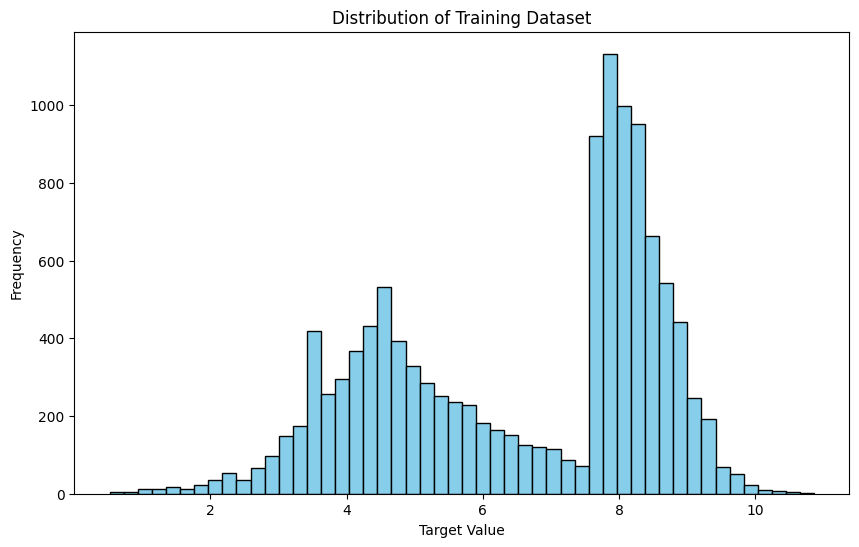

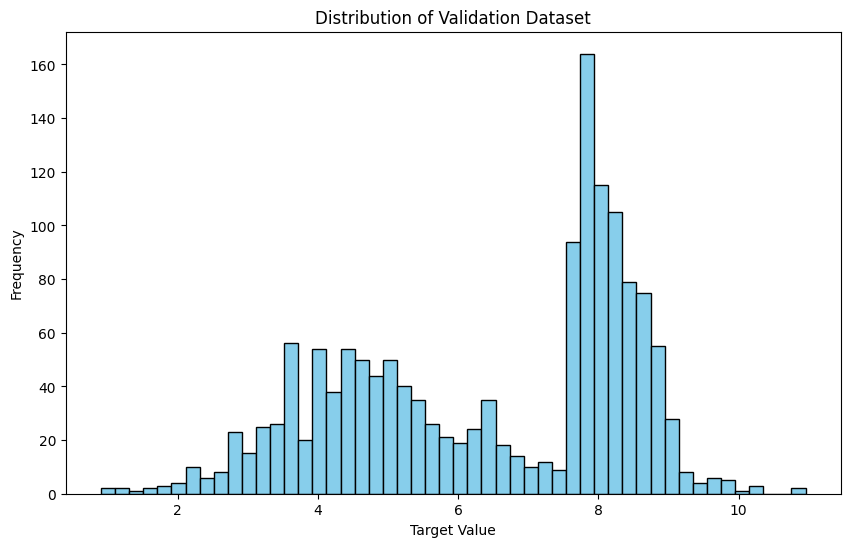

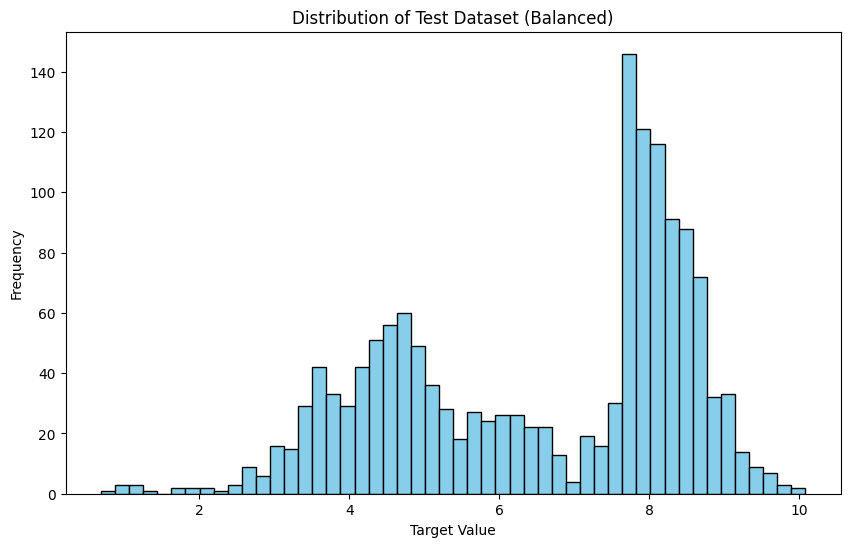

Statistics for Training Dataset:
Mean: 6.57
Median: 7.66
Standard Deviation: 2.01
Min: 0.52
Max: 10.86

Statistics for Validation Dataset:
Mean: 6.45
Median: 7.38
Standard Deviation: 2.02
Min: 0.90
Max: 10.95

Statistics for Test Dataset (Balanced):
Mean: 6.55
Median: 7.63
Standard Deviation: 1.95
Min: 0.68
Max: 10.09



In [29]:
import matplotlib.pyplot as plt
def plot_distribution(labels, title):
    labels_flat = labels.flatten()  # Flatten the labels to 1D
    plt.figure(figsize=(10, 6))
    plt.hist(labels_flat, bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {title}')
    plt.xlabel('Target Value')
    plt.ylabel('Frequency')
    plt.show()

# Plot distributions for each dataset
plot_distribution(train_labels, 'Training Dataset')
plot_distribution(val_labels, 'Validation Dataset')
plot_distribution(test_labels, 'Test Dataset (Balanced)')

# Print basic statistics
def print_statistics(labels, title):
    labels_flat = labels.flatten()  # Flatten the labels to 1D
    print(f"Statistics for {title}:")
    print(f"Mean: {np.mean(labels_flat):.2f}")
    print(f"Median: {np.median(labels_flat):.2f}")
    print(f"Standard Deviation: {np.std(labels_flat):.2f}")
    print(f"Min: {np.min(labels_flat):.2f}")
    print(f"Max: {np.max(labels_flat):.2f}\n")

# Print statistics for each dataset
print_statistics(train_labels, 'Training Dataset')
print_statistics(val_labels, 'Validation Dataset')
print_statistics(test_labels, 'Test Dataset (Balanced)')
